# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** 26

**Author 1 (sciper):** Andrea Oliveri (283506)  
**Author 2 (sciper):** Charles Berger (272018)   
**Author 3 (sciper):** Chun Hei Michael Chan (311722)

**Release date:** 12.03.2021  
**Due date:** 26.03.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* Additional method of your choice (5 pts)

Each section should display the resulting segmentation as well as the size in pixel of the detected region. Comment each method limitations and/or advantages.

### 1.1 Brain image visualization

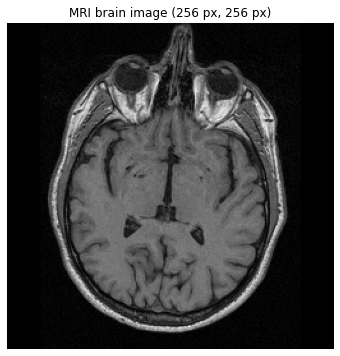

(256, 256)

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

brain_im.shape

### 1.2 Region growing (5pts)

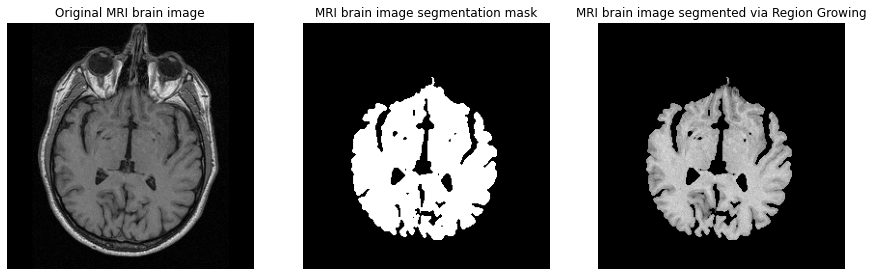

Number of pixels in brain: 15935


In [3]:
import cv2 as cv
import numpy as np

def get_neighbours_not_in_region(pixel, output):
    """
    Function returning a list containing the 8 neighbours of pixel which are not already segmented 
    in output (ignoring those neighbours which would fall out of the image boundaries).
    
    Args:
        pixel::[tuple]
            Tuple of form (line, col) containing the pixel we want to compute the neighbours of.
        output::[np.array]
            Output segmentation mask of same shape as original grayscale image.
    Returns:
        neighbours_not_in_region::[list]
            List of pixels (tuples of same form as pixel parameter), containing the neighbours of
            pixel parameter which are not already segmented in output and that are in image boundaries.
    """
    pixel_line , pixel_col  = pixel
    image_lines, image_cols = output.shape
    
    neighbours_not_in_region = []
    for delta_line in [-1, 0, +1]:
        neighbour_line = pixel_line + delta_line
        
        # If we are outside the image, skip these pixels.
        if neighbour_line < 0 or neighbour_line >= image_lines:
            continue
        
        for delta_col in [-1, 0, +1]:
            # If we are on current pixel, skip this pixel.
            if delta_line == 0 and delta_col == 0:
                continue
            
            neighbour_col = pixel_col + delta_col
            
            # If we are outside the image, skip these pixels.
            if neighbour_col < 0 or neighbour_col >= image_cols:
                continue
            
            # Add neighbour if not already in the region.
            neighbour = (neighbour_line, neighbour_col)
            if not output[neighbour]:
                neighbours_not_in_region.append(neighbour)
                
    return neighbours_not_in_region
    

def segment_region_growing(image, seed, threshold, neighbourhood_size):
    """
    Function returning a segmentation mask computed by region growing from seed.
    
    Args:
        image::[np.array]
            Input image on which we want to perform region growing.
        seed::[tuple]
            Tuple of form (line, col) containing the pixel we want to start growing the region from.
        threshold::[float]
            Threshold for deciding if new pixel is included in region.
        neighbourhood_size::[int]
            Size of the neighbourhood of current pixel on which to calculate the mean. Must be >0 and
            if even number is given, neighbourhood_size+1 is used instead.
    Returns:
        output::[np.array]
            Output segmentation mask performed by region growing with seed as starting pixel.
    """
    assert(neighbourhood_size >= 0)
    delta_lower = -(neighbourhood_size//2)
    delta_upper = +(neighbourhood_size//2)+1
        
    output = np.zeros_like(image, dtype = np.bool_)
    
    pixels_to_treat = [seed]
    
    while pixels_to_treat:
        current_pixel = pixels_to_treat[-1]
        pixels_to_treat.pop()
        
        output[current_pixel] = True
        
        for neighbour in get_neighbours_not_in_region(current_pixel, output):            
            neighbourhood_mean = float(np.mean(image[current_pixel[0]+delta_lower:current_pixel[0]+delta_upper, 
                                                     current_pixel[1]+delta_lower:current_pixel[1]+delta_upper]))
            
            if abs(neighbourhood_mean - image[neighbour]) < threshold:
                pixels_to_treat.append(neighbour)
                
    return output
        
        
# Region Growing parameters.
seed      = (140, 140)
threshold = 4
neighbourhood_size = 1

# Filter parameters.
size_median_filter_image = 3
size_median_filter_mask  = 3
           

# Applying a median filter in order to reduce the noise while keeping the edges clear.
brain_median = cv.medianBlur(brain_im, size_median_filter_image)

# Segmenting.
mask = segment_region_growing(brain_median, seed, threshold, neighbourhood_size)

# Applying a median filter in order to close small holes in the mask.
mask = cv.medianBlur(mask.astype(np.uint8), size_median_filter_mask)


# Display Segmented Brain.
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(brain_im, cmap='gray')
ax[0].set_title('Original MRI brain image')
ax[0].axis('off')
ax[1].imshow(mask, cmap='gray')
ax[1].set_title('MRI brain image segmentation mask')
ax[1].axis('off')
ax[2].imshow(np.where(mask, brain_im, 0), cmap='gray')
ax[2].set_title('MRI brain image segmented via Region Growing')
ax[2].axis('off')
plt.show()

# Count number of pixels in brain.
print(f"Number of pixels in brain: {mask.sum()}")

<b>DISCUSSION</b>
<br>
##### Description of the processing : 

- Pre-processing : 
    <br>

    - We apply a median filter to remove the high frequency noise while preserving the edges. The optimal size of this filter was determined empirically.
    <br>

    - We define the threshold and size of neighbourhood we want to use in the calculation to choose if a new pixel is to be included in the region. These values were determined through experimentation. The best results were obtained for a neighbourhood of size 1 (only the current pixel is considered when deciding whether to include its neighbour in the region).
    <br>

    - We define the seed from which to start the region growing algorithm. The seed is design such that the pixel is inside the brain.


- Processing : 
    <br>
    
    - Initialize list of pixels to treat with seed.
    <br>

    - While there are still pixels to treat:    
        - Add pixel to region.
        - Remove pixel from list of pixels to treat.
        - For all its neighbours which are not already part of the region:
            - Test condition for being added into region (intensity of neighbour pixel must be closer than threshold to the mean intensity of the neighbouring of the current pixel).
            - If condition satisfied, neighbour is added to pixels to treat list (and will later be added to region). Otherwise, nothing is done at this stage but this same neighbouring pixel can be tested again in case another one of its neighbours gets added to the region.


- Post-processing : 
    <br>
    
    - We apply a median filter on the mask to suppress the small holes while preserving the contours of the mask.


##### General comment on method

- Region growing using a fixed threshold and only comparing the intensity of a pixel with respect to its neighbours is sensible to high-frequency noise. For this reason, in order to obtain good results we applied a median filter before performing region growing to attenuate the high-frequency noise while still preserving the edges in the input image. 
    <br/>

- Region growing using a fixed threshold and only comparing the intensity of a pixel with respect to its neighbours is sensible to poor contrast on the edge of desired segmentation region. To account for this, the threshold and size of the median filter applied in pre-processing have to be carefully chosen.


##### Comment on results

- The brain is very well segmented, and almost no parts of the image not part of the brain are segmented.
  <br/>

- Dark regions inside the brain are mostly correctly recognized as not part of the brain (small number of false positives).
  <br/>
  
- Small imperfection on upper side of brain in which a small part of the cartilage is segmented too (a small false positive).


##### Comparison to other methods

- Number of pixels detected: a total of `15935 pixels` were classified as belonging to the brain using region growing. This value is in the same range as the one obtained by contour detection (15485 pixels) and, despite being slightly lower, also very close to that obtained by custom thresholding in the additional methods (16734 pixels).
  <br/>
  
- Holes in the final mask: the vast majority of holes in brain visible in segmentation mask actually come from dark regions in the brain image, and do not therefore represent something we would like to get rid of.
  <br/>
  
- Missing brain regions: no parts of the brain were missed using this segmentation technique.
  <br/>
  
- Oversegmentation (False Positives): with the exception of a small part of cartilage towards the upper side of the brain, most of the pixels not belonging to the brain are correctly left out of the segmentation mask.


##### Improvements and alternative approaches 

- A different rule could be used to decide whether the neighbour pixel to the current one is added to the region, for exemple by taking into account the average of values across the whole already segmented region. 
  <br/>

- A technique to increase the contrast between the brain and the rest of tissues would make this method much more resistant to slight changes in the chosen threshold and reduce false positives.
  <br/>
  
- A morphological closing could be used instead of a median filter to close the holes in the final mask.

### 1.3 Contour detection (5pts)

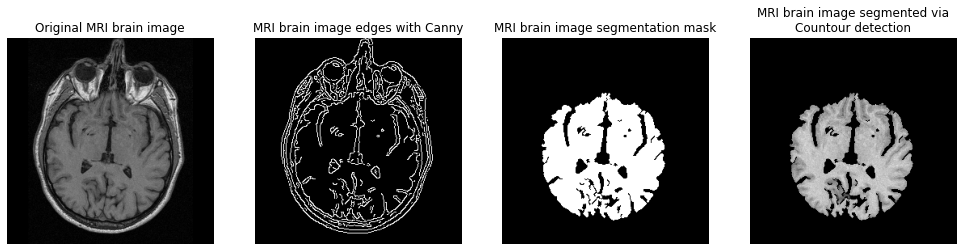

Number of pixels in brain: 15485


In [4]:
def segment_countour_detection(image, canny_threshold_low, canny_threshold_high, dilation_structuring_element, seed):
    """
    Function returning the results of the Canny Edges detector and the image after
    doing the connected component inside the brain to isolate it.
    
    Args:
        image::[np.array]
            Input image on which we perform contour edge detection.
        canny_threshold_low::[float] 
            Value of the low threshold for Canny edge detector's hysteresis.
        canny_threshold_high::[float]
            Value of the high threshold for Canny edge detector's hysteresis.
        dilation_structuring_element::[np.array]
            Kernel used to dilate and connected the edges made by Canny edge detector.
        seed::[tuple]
            Tuple of form (line, col) containing a pixel we know is in the brain.
    Returns: 
        canny_detector::[np.array]:
            Image output of the Canny detector.
        mask::[np.array]:
            Output segmentation mask of the brain.
    """
    # Edge detection.
    canny_detector = cv.Canny(brain_median, canny_threshold_low, canny_threshold_high)
    
    # In order to segment the brain, we must first close the edges.
    # To do so, we dilate the image edges.
    dilated = cv.dilate(canny_detector, dilation_structuring_element)
    
    # Segmenting with cv.connectedComponent requires background of image to be black and 
    # foreground to be white. Thus we take the negative of the image.
    dilated = np.where(dilated > 0, 0, 255).astype(np.uint8)

    # Segmenting.
    _, segmented = cv.connectedComponents(dilated)
    mask         = segmented == segmented[seed]

    # Dilation of segmented area to counteract previous dilation of borders.
    mask = cv.dilate(mask.astype(np.uint8), kernel)

    return canny_detector, mask
    
    
# Canny Edge Detector Parameters.
threshold_low  = 60
threshold_high = 100

# Filter parameters.
size_median_filter_image = 3

# Dilation structuring element.
kernel = cv.getStructuringElement(cv.MORPH_CROSS, (3,3))

# Pixel in brain.
seed = (140, 140)


## Applying a median filter in order to reduce the noise while keeping the edges clear.
brain_median = cv.medianBlur(brain_im, size_median_filter_image)


# Segmenting.
canny_detector, mask = segment_countour_detection(brain_im, threshold_low, threshold_high, kernel, seed)


# Display Segmented Brain
fig, ax = plt.subplots(1, 4, figsize=(17, 5))
ax[0].imshow(brain_im, cmap='gray')
ax[0].set_title('Original MRI brain image')
ax[0].axis('off')
ax[1].imshow(canny_detector, cmap='gray')
ax[1].set_title('MRI brain image edges with Canny')
ax[1].axis('off')
ax[2].imshow(mask, cmap='gray')
ax[2].set_title('MRI brain image segmentation mask')
ax[2].axis('off')
ax[3].imshow(np.where(mask, brain_im, 0), cmap='gray')
ax[3].set_title('MRI brain image segmented via\nCountour detection')
ax[3].axis('off')
plt.show()

# Count number of pixels in brain.
print(f"Number of pixels in brain: {mask.sum()}")

<b>DISCUSSION</b>
<br>
 
##### Description of the processing : 
- Pre-processing : 
    <br>

    - We apply a median filter to remove the high frequency noise while preserving the edges. The optimal size of this filter was determined empirically.
    <br>

    - We define the lower and upper threshold for the Canny detector. These values were determined through experimentation.
    <br>

    - We define the seed value for the connected components algorithm. The seed is design such that the pixel is inside the brain.


- Processing : 
    <br>

    - We apply the Canny edge detector on the blurred image with the pre-defined upper ad lower threshold.
    <br>

    - To close the edges, we dilate the image with a $3 \times 3$ cross structuring element. This structuring element was chosen in order to efficiently close with vertical and horizontal lines the edges trying to avoid disrupting the smaller details in the output of the Canny edge detector.


- Post-processing : 
    <br>

    - Since cv.connectedComponent requires background of image to be black and the object to be white, we take the negative of the previous picture and apply the connected components function. We only keep the region containing the seed. Thanks to this step, we extracted the brain from the picture.
    <br>

    - We then dilate (using the same structuring element) to counteract the effect on the size of segmented region of the dilation of borders done before negating and isolating the brain region.
    <br>


##### General comment on method

- Canny edge detector is a robust edge detection algorithm that tries to detect edges by looking at the smoothed image gradient's maxima. Since the gradient is sensible to high-frequency noise, the algorithm applies a gaussian filter in order to make the gradient calculation more robust. However, in our case, the image's noise was still too high and it detected too much edges such that some part of the brain's regions, after segmentation,  were missing. We had to apply a median filter before to the input image to remove the noise while still conserving the brain's edges. 
    <br/>

- By changing the size of the median or the structuring element used in the pre-processing step, we can tune how much of the brain is actually segmented, however this has to be done carefully to avoid segmenting undesired parts of the image or loss of fine details in the brain structure.


##### Comment on results

- The brain is overall well segmented, with no parts of the image not part of the brain being segmented.
  <br/>

- Dark regions inside the brain are mostly correctly recognized as not part of the brain (small number of false positives), despite perheaps being a tiny bit larger then desired.
  <br/>

##### Comparison to other methods

- Number of pixels detected: a total of `15485 pixels` were classified as belonging to the brain using contour detection. This value is in the same range as the one obtained by region growing (15935 pixels) and, despite being slightly lower, also very close to that obtained by custom thresholding in the additional methods (16734 pixels).
  <br/>
  
- Holes in the final mask: the vast majority of holes in brain visible in segmentation mask actually come from dark regions in the brain image, and do not therefore represent something we would like to get rid of.
  <br/>
  
- Missing brain regions: no parts of the brain were missed using this segmentation technique.
  <br/>
  
- Oversegmentation (False Positives): the vast majority of the pixels not belonging to the brain are correctly left out of the segmentation mask.


##### Improvements and alternative approaches 

- Possible alternatives to using the Canny edge detector is to use a Marr-Hildreth algorithm or a Laplacian of Gaussian algorithm. The second alternative was tested in our implementation but results were not satisfying as the input image was too noisy even after applying a strong low pass filter and the edge detector could not extract the brain area.
  <br/>
  
- A different structuring element could be designed instead of the $3 \times 3$ cross, such as a rectangular or ellipsoidal structuring element. This may however result in the loss of the finer details in the segmentation mask. 

### 1.4 Additional method (5pts)

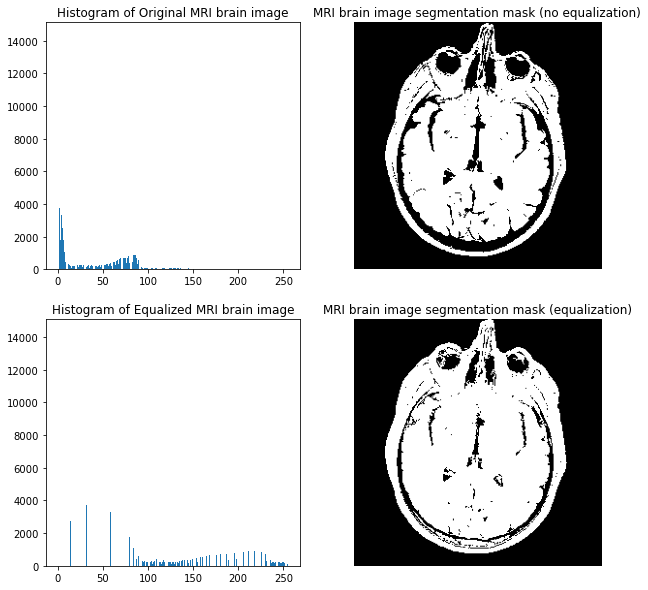

Number of pixels in brain (no equalization): 25853
Number of pixels in brain (equalization)   : 29017


In [5]:
def segment_otsu_thresholding(image, seed):
    """
    Function returning a segmentation mask computed by applying histogram
    equalization on input image followed by Otsu's thresholding.
    
    Args:
        image::[np.array]
            Input image on which we perform segmentation.
        seed::[tuple]
            Tuple of form (line, col) containing a pixel we know is in the brain.
    Returns:
        mask::[np.array]:
            Output segmentation mask of the brain obtained by Otsu's thresholding
            without histogram equalization.
        mask_equalized::[np.array]:
            Output segmentation mask of the brain obtained by Otsu's thresholding
            with histogram equalization.
        histogram::[np.array]:
            Computed histogram of input image.
        histogram_equalized::[np.array]:
            Computed histogram of input image after histogram equalization.
    """
    # Histogram Equalization.
    image_equalized = cv.equalizeHist(image)

    # Otsu's thresholding with and without equalization.
    _, thresholded           = cv.threshold(image          , 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    _, thresholded_equalized = cv.threshold(image_equalized, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    # Segmenting.
    _, labels           = cv.connectedComponents(thresholded)
    _, labels_equalized = cv.connectedComponents(thresholded_equalized)

    mask           = (labels == labels[seed]).astype(np.uint8)
    mask_equalized = (labels_equalized == labels_equalized[seed]).astype(np.uint8)

    # Computing histograms for visualization.
    histogram          , _ = np.histogram(image          , bins = 256, range = (0, 256))
    histogram_equalized, _ = np.histogram(image_equalized, bins = 256, range = (0, 256))
    
    return mask, mask_equalized, histogram, histogram_equalized


# Pixel in brain.
seed = (140, 140)


# Custom Segmenting.
mask, mask_equalized, histogram, histogram_equalized = segment_otsu_thresholding(brain_im, seed)

# Display Segmented Brain.
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].bar(range(0, 256), histogram)
ax[0, 0].set_title('Histogram of Original MRI brain image')
ax[0, 1].imshow(mask, cmap='gray')
ax[0, 1].set_title('MRI brain image segmentation mask (no equalization)')
ax[0, 1].axis('off')
ax[1, 0].bar(range(0, 256), histogram_equalized)
ax[1, 0].set_title('Histogram of Equalized MRI brain image')
ax[1, 1].imshow(mask_equalized, cmap='gray')
ax[1, 1].set_title('MRI brain image segmentation mask (equalization)')
ax[1, 1].axis('off')
plt.show()

# Count number of pixels in brain.
print(f"Number of pixels in brain (no equalization): {mask.sum()}")
print(f"Number of pixels in brain (equalization)   : {mask_equalized.sum()}")

<b>DISCUSSION</b>
<br>
<b>DISCUSSION</b>
<br>
##### Description of the processing : 

- Pre-processing : 
    <br>
    
    - We define the seed value for the connected components algorithm. The seed is design such that the pixel is inside the brain.
    <br>

    - We test Otsu's thresholding under two cases: when the input image is not changed and when histogram equalization is applied as pre-processing.


- Processing : 
    <br>
    
    - We threshold the images using Otsu's thresholding. 
    <br>

    - We apply the connected components function. We only keep the region containing the seed.


- Post-processing :
    <br>
    
    - No post-processing was performed.


##### General comment on method

- Otsu's thresholding is an automatic thresholding method capable of thresholding very well images for which the histogram clearly shows two peaks. In the case of the original image, tis is the case, however the pixels we were really interested in were only a subset of one of the two peaks, and thus was not suitable to be automatically segmented via Otsu's thresholding. Equalizing the image, as expected, did not improve the situation, and it actually made it worse as after equalization the peaks in the histogram are not clearly identifiable anymore. 


##### Comment on results

- The brain is segmented in both cases, unfortunately all the bones and other tissues surrounding it are also segmented. This is because all these pixels belong to the same peak (that of non-black intensities) in the image histogram, so Otsu's thresholding assumes we wish to distinguish this peak from the other one, rather than partition this peak.
  <br/>

- The result obtained after histogram equalization is even worse than that obtained without equalizing as after equalization the peaks in the histogram are not clearly identifiable anymore. 


##### Comparison to other methods

- Number of pixels detected: the number of pixels detected using this method is erroneour and much larger than that obtained via other methods due to a large number of false positives.
  <br/>
  
- Holes in the final mask: the few small holes in the mask are not the main concern with these results. 
  <br/>
  
- Missing brain regions: no brain regions were missed using this segmentation technique (nor bones, for that matter).
  <br/>
  
- Oversegmentation (False Positives): this method segmented all the bones and tissues around the brain as well.


##### Improvements and alternative approaches 

- A different thresholding technique should be used, one for which the peak containing the pixels in the second peak of the histogram could be only partially represented in the final mask, such as the next method proposed.
  <br/>

- If we could increase the contrast between the brain and the rest of tissues enough, we may perheaps hope to obtain usable results with this technique.

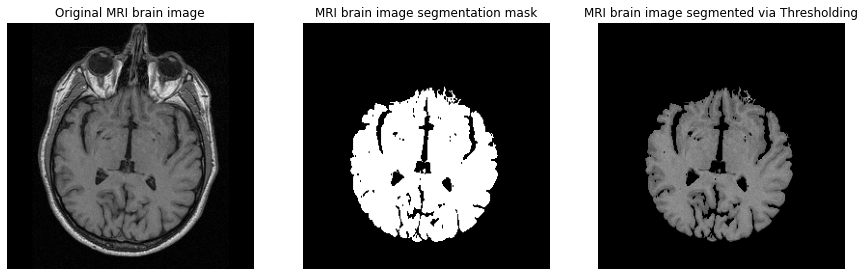

Number of pixels in brain: 16734


In [6]:
def segment_custom_thresholding(image, threshold_low, threshold_high, seed):
    """
    Function returning a segmentation mask computed by thresholding the
    input image between threshold_low and threshold_high and keeping only
    the region containing seed.
    
    Args:
        image::[np.array]
            Input image on which we perform segmentation.
        threshold_low::[float] 
            Value of the low grayscale threshold for image.
        threshold_high::[float]
            Value of the high grayscale threshold for image.
        seed::[tuple]
            Tuple of form (line, col) containing a pixel we know is in the brain.
    Returns:
        mask::[np.array]:
            Output segmentation mask of the brain.
    """

    # Carefully chosen thresholding.
    thresholded = np.logical_and(brain_im > threshold_low, brain_im < threshold_high).astype(np.uint8)

    # Segmenting.
    _, labels   = cv.connectedComponents(thresholded)
    mask        = (labels == labels[seed]).astype(np.uint8)
    
    return mask


# Thresholding parameters.
threshold_low  = 50
threshold_high = 95

# Pixel in brain.
seed = (140, 140)


# Segmenting.
mask = segment_custom_thresholding(brain_im, threshold_low, threshold_high, seed)

# Closing to remove small holes.
mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_RECT, (1,2)))


# Display Segmented Brain.
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(brain_im, cmap='gray')
ax[0].set_title('Original MRI brain image')
ax[0].axis('off')
ax[1].imshow(mask, cmap='gray')
ax[1].set_title('MRI brain image segmentation mask')
ax[1].axis('off')
ax[2].imshow(np.where(mask, brain_im, 0), cmap='gray')
ax[2].set_title('MRI brain image segmented via Thresholding')
ax[2].axis('off')
plt.show()

# Count number of pixels in brain.
print(f"Number of pixels in brain: {mask.sum()}")

<b>DISCUSSION</b>
<br>
##### Description of the processing : 

- Pre-processing : 
    <br>

    - We define the lower and upper threshold to use to isoltate the pixels making up the brain from the rest. These values have been empirically determined.
    <br>

    - We define the seed value for the connected components algorithm. The seed is design such that the pixel is inside the brain.


- Processing : 
    <br>
    
    - Threshold such that all pixels outside the desired range are put to 0 and all those inside to 1. 
    <br>

    - We apply the connected components function. We only keep the region containing the seed.


- Post-processing : 
    <br>
    
    - We apply a morphological closing using a thin horizontal line as structuring element such that we are able to close the very tiny holes present in the obtained mask without damaging the vertical lines present at the top and bottom of the brain.


##### General comment on method

- Thresholding with carefully chosen values may be a very effective way of segmenting an image if the pixels we are interested in all have values in a defined range and all other pixels have values outside this range. However, the choice of the thresholds may be different for each image, even if they visually appear similar, and is not always guaranteed to work. 
    <br/>

- Thresholding with carefully chosen values is also very susceptible to high-frequency noise in the desired area, which would need to be filtered out before applying the thresholding or would need to be corrected from the mask. 


##### Comment on results

- The brain is very well segmented, and almost no parts of the image not part of the brain are segmented.
  <br/>

- Dark regions inside the brain are mostly correctly recognized as not part of the brain (small number of false positives).
  <br/>
  
- Small imperfection on upper-right side of brain in which a small part of bone is segmented too (a small false positive).


##### Comparison to other methods

- Number of pixels detected: a total of `16734 pixels` were classified as belonging to the brain using thresholding pixels in a carefully chosen range. This value is slightly larger, but still very close to those obtained by region growing (15935 pixels) and contour detection (15485 pixels).
  <br/>
  
- Holes in the final mask: the vast majority of holes in brain visible in segmentation mask actually come from dark regions in the brain image, and do not therefore represent something we would like to get rid of.
  <br/>
  
- Missing brain regions: no parts of the brain were missed using this segmentation technique.
  <br/>
  
- Oversegmentation (False Positives): with the exception of a small part of bone towards the upper-right side of the brain, most of the pixels not belonging to the brain are correctly left out of the segmentation mask.


##### Improvements and alternative approaches 

- Finding a way to increase sufficiently the contrast between the brain and the rest of tissues would make finding suitable threshold values to achieve desired results much simpler, and the process may even be authomatized by using algoriths such as Otsu's thresholding.
  <br/>
  
- A different structuring element could be used to close a few more small holes in the final mask, but it would need to be very carefully chosen to avoid damaging the desired holes and vertical stripes in the segmentation mask. 
  <br/>

- A median filter may also be used to remove the high-frequency noise from the input image before thresholding, but our tests did not show an improvement of our results over the current one. It could also be used to remove small holes from the final mask, but our tests showed that even just a $3 \times 3$ median filter already closes desired holes in the mask.

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

### 2.1 Visualization

In [7]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


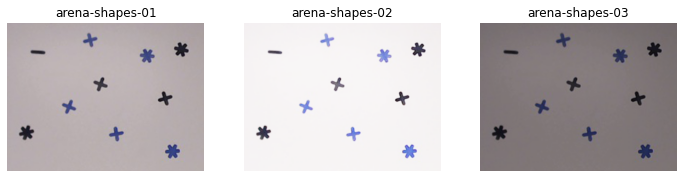

In [8]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color (5 pts)

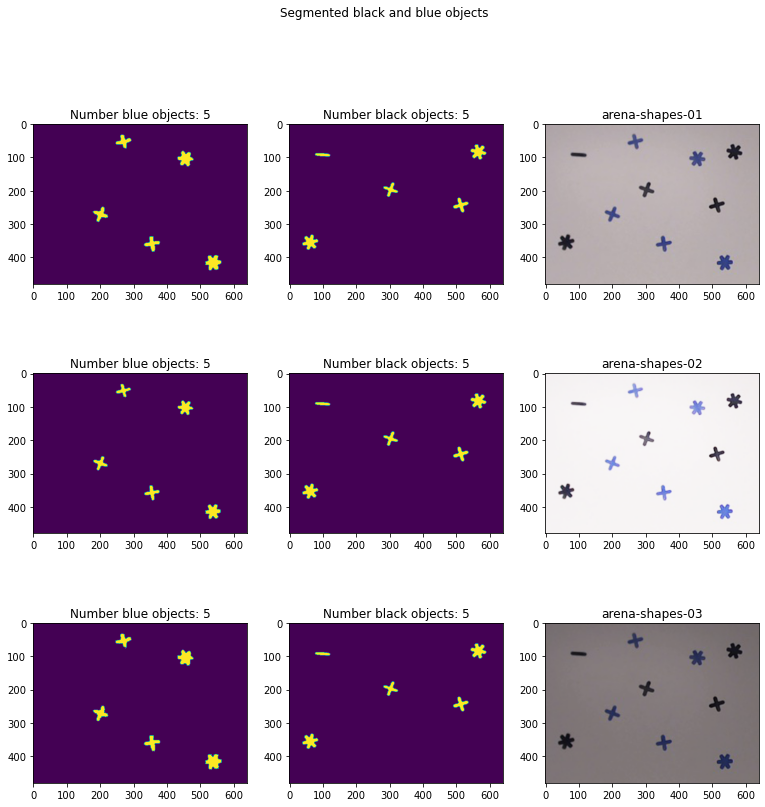

In [9]:
def get_blue_black_masks(image):
    """
    Function returning mask of pixles in image which are in the color range of blue and black.
    
    Args:
        image::[np.array]
            Input image for which we want to detect the blue and black pixels.
    Returns:
        blue_mask::[np.array]
            Mask of same size as input image containing the detected blue pixels in image.
        black_mask::[np.array]
            Mask of same size as input image containing the detected black pixels in image.
    """
    image_hsv = cv.cvtColor(image, cv.COLOR_RGB2HSV)
    
    image_hsv[:,:,2] = cv.equalizeHist(image_hsv[:,:,2])
    
    blue_mask  = cv.inRange(image_hsv, (90, 50, 4), (135, 255, 255))
    black_mask = cv.inRange(image_hsv, (0, 0, 0)  , (180, 255, 3))
    
    return blue_mask, black_mask

def detect_same_object(component1, component2, tolerance):
    """
    Function returning whether two components are sufficiently close to be classified as belonging
    to same object. 
    
    Args:
        component1::[dict]
            Dictionary of form {"centroid": np.array, "width": float, "height": float} containing
            information about the first connected component.
        component2::[dict]
            Dictionary of form {"centroid": np.array, "width": float, "height": float} containing
            information about the second connected component.        
        tolerance::[float]
            Tolerance in inequality check to decide whether components are close enough.
    Returns:
        output::[boolean]
            True if the components are close enough to probably be part of the same object, False
            otherwise.
    """
    distance = np.linalg.norm(component1["centroid"] - component2["centroid"])
    radius_component1 = (component1["width"] + component1["height"]) / 4 
    radius_component2 = (component2["width"] + component2["height"]) / 4 

    if distance <= radius_component1 + tolerance or distance <= radius_component2 + tolerance:
        return True
    
    return False

def get_objects_from_mask(mask, tolerance = 10, min_size = 50):
    """
    Function returning segmentation mask of objects obtained by cleaning the color mask passed
    as parameter. 
    
    Args:
        mask::[np.array]
            Image mask obtained by color thresholding.
        tolerance::[float]
            Tolerance in inequality check to decide whether components are close enough.
        min_size::[int]
            Minimum size in number of pixels of component to be considered a valid object.
    Returns:
        objects_mask::[np.array]
            Mask of same size as input mask containing segmenting the objects large enough and
            grouped if they are close enough.
    """
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(mask)
    
    # Merging close components that belong to same object, skipping background labeled 0.
    new_labels = {}
    for component1 in range(1, num_labels):
        parameters1 = {"centroid": np.array(centroids[component1]), "width": stats[component1, cv.CC_STAT_WIDTH], "height": stats[component1, cv.CC_STAT_HEIGHT]}
        for component2 in range(component1 + 1, num_labels):
            parameters2 = {"centroid": np.array(centroids[component2]), "width": stats[component2, cv.CC_STAT_WIDTH], "height": stats[component2, cv.CC_STAT_HEIGHT]}
            if detect_same_object(parameters1, parameters2, tolerance):
                new_labels[component2] = component1
    
    # Solves conflicts caused by values in dictionary which are also keys.
    key_value_conflicts = [key for key, value in new_labels.items() if value in new_labels.keys()]
    while key_value_conflicts:
        for conflict in key_value_conflicts:
            new_labels[conflict] = new_labels[new_labels[conflict]]
        key_value_conflicts = [key for key, value in new_labels.items() if value in new_labels.keys()]
    
    # Merges close components that belong to same object.
    for old_component, new_component in new_labels.items():
        labels[labels == old_component] = new_component
    
    # Removes too small groups (merges them with background).
    unique, counts = np.unique(labels, return_counts=True)
    for component, n_pixels in zip(unique, counts):
        if n_pixels < min_size:
            labels[labels == component] = 0
           
    # Creates mask from components not in background.
    objects_mask = labels > 0
        
    return len(np.unique(labels[objects_mask])), objects_mask


fig, ax = plt.subplots(3, 3, figsize = (13,13))
fig.suptitle('Segmented black and blue objects')
for idx, (image, name) in enumerate(zip(images, im_names), start=0):
    
    blue_mask, black_mask = get_blue_black_masks(image)
    
    n_objects_blue , mask_objects_blue  = get_objects_from_mask(blue_mask)
    n_objects_black, mask_objects_black = get_objects_from_mask(black_mask)

    ax[idx, 0].imshow(mask_objects_blue)
    ax[idx, 0].set_title(f'Number blue objects: {n_objects_blue}')
    ax[idx, 1].imshow(mask_objects_black)
    ax[idx, 1].set_title(f'Number black objects: {n_objects_black}')
    ax[idx, 2].imshow(images[idx])
    ax[idx, 2].set_title(name)

<b>DISCUSSION</b>
<br>
##### Description of the processing : 

- Pre-processing : 

    - We first convert our RGB image into the HSV colorspace, as isolating a specific color by thresholding is easier to do in HSV colorspace then it is in the RGB colorspcae. This also allows us to obtain a brightness channel of the image, which we will later use to perform intensity normalization to be robust to differences in brightness.
    <br>

    - We apply histogram equalization on the brightnesses channel of our image as a technique of intensity normalization.


- Processing : 
    
    - We isolate the black and blue pixels by thresholding the HSV image between carefully selected lower and upper value for each channel. This choice was made using pictures of the HSV cone such as the following ones. To isolate the black pixels we allow any hue and saturation as long as the brightness is sufficiently small, and to isolate the blue pixels we allow any saturation and brightness as long as brightness is not too low and hue is in the blue range. 
    <div> <img src="../data/hsv.png" width="600"></div>

    <br>

    - We segment the resulting binary images using connected components, and we merge those regions which are sufficintly close.
    
    
- Post-processing : 
    
    - If any regions containing very small number of pixels still remain after this process, they are removed as they don't belong to any of the objects we are interested in and we don't want to count them as a separate object.


##### General comment on method
- Thresholding with carefully chosen values may be a very effective way of segmenting an image if the pixels we are interested in all have values in a defined range and all other pixels have values outside this range. However, this may require fine-tuning depending on the image and is, in general, not always guaranteed to work. 
    <br>

- Thresholding with carefully chosen values is also very susceptible to high-frequency noise in the desired area, which would need to be filtered out before applying the thresholding or would need to be corrected from the final mask.


##### Comment on results
- The correct number of objects were detected, and the shape of the segmented objects closely resembles that of the objects in the each of the input images.
<br>

- The metod we implemented was robust enough to detect the correct number of objects irrespective of the overall illumination of the image.
<br>

- The accuracy of the shape of the segmented objects is overall good for all input images, but varies slightly varied depending on the illumination. 


##### Improvements and alternative approaches 
- Estimate the threshold used to remove too small objects based on their pixel count not as a fixed value but by estiating it based on the size of the larger objects which we know we want to keep.
<br>

- Alternative methods to identify the objects by thresholding by their color include for instance k-means (used in conjunction with the elbow method to determine the correct the number of objects in the image).

### 2.3 Total area (in pixels) of each color (5 pts)

In [10]:
for image, name in zip(images, im_names):
    blue_mask, black_mask = get_blue_black_masks(image)
    
    _, mask_objects_blue  = get_objects_from_mask(blue_mask)
    _, mask_objects_black = get_objects_from_mask(black_mask)
    
    n_blue  = np.sum(mask_objects_blue)
    n_black = np.sum(mask_objects_black) 
    
    print(f'There are {n_blue} blue pixels and {n_black} black pixels')

There are 5214 blue pixels and 4192 black pixels
There are 4423 blue pixels and 4192 black pixels
There are 5433 blue pixels and 4182 black pixels


<b>DISCUSSION</b>
<br>

##### Description of the Processing
- `We employ the same method as in part 2.2` in order to segment out the target objects. The number of pixels of each color is then just obtained by counting the non-zero pixel in the segmentation mask. 


##### General comment on method
- `As the method is the same as that employed in section 2.2, the same considerations apply.`


##### Comment on results
- The number of pixels of each color is consistent for the three images with different illuminations, with a small relative variation of this number across images. This variation is much lower for the black pixel count compared to the blue pixel count.
<br>

- By visualizing the masks of the segmented objects we can see that they are generally well segmented, but the shape of blue objects is less accurate when illumination is dimmer, which reflects in our results showing a larger blue pixel count under these conditions.


##### Improvements and alternative approaches 
- `As the method is the same as that employed in section 2.2, the same improvements apply.`
<br>

- In order to improve the quality of the segmented objects and hence the pixel count we could try apply a high-pass filter to sharpen transitions between the objects and the background.
<br>

- For this specific task, region growing with a carefully selected growing condition could work very well. The seeds could be selected either manually or by a very rough thresholding over the desired color.